# Feature Permutation Importance

A trained multimodal model was used to measure the importance of each spectral band from the multispectral images. In this test, the selected band has the values position randomised which breaks the band contribution to grain yield preidction, we then measure if the permutation has caused the model to decrease the prediction performance. 

In [2]:
## Import libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
import fastai
from fastai.tabular.all import *
from fastai.data.load import _FakeLoader, _loaders

import torch
from glob import glob

import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os

# Custom functions
from msi_utils import *
from fold_utils import * 
from multimodal_utisl import *
from multimodal_model import *

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Fastai and fastcore versions have to be above 

fastai : 2.1.2 (at the moment 2.3.0)
fastcore: 1.3.1 (1.3.19)
torch : 1.7.0 ('1.8.1+cu102')

# Reference tables
The spectral and df data has to be loaded in the same order, so the modules can share the weights on matching samples 

In [3]:
path = Path('/data/g2f_data/input_data/')

In [6]:
df_test = pd.read_csv('/data/fielddata/df_test.csv')
df_train_val = pd.read_csv('/data/fielddata/df_train_val.csv')

In [7]:
# Use random splitter function from fastai
splitter = RandomSplitter(seed=42)
splits = splitter(range_of(df_train_val))
splits

((#3103) [240,1404,2885,809,2650,1972,1931,1957,2366,2825...],
 (#775) [484,3113,2274,792,3440,493,1538,2182,588,3249...])

# Feature importance by Permutation


## RGB - alone

In [17]:
def load_npy(fn, shuffle_band=[3,4,5,6,7,8,9,10,11,12]):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    for band in shuffle_band:
        bshuffle = im[:,:,band].flatten()
        np.random.shuffle(bshuffle)
        im[:,:,band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

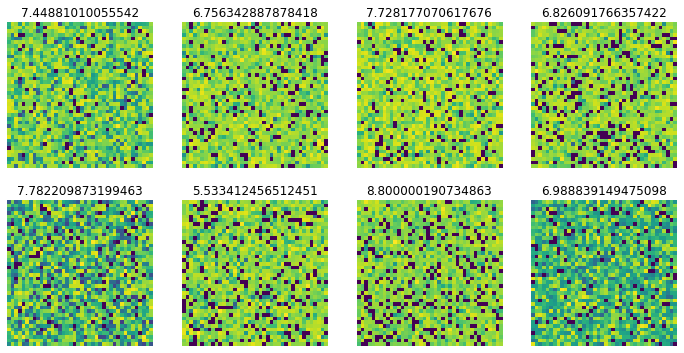

In [18]:
# RGB
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl.show_batch(channels=7)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


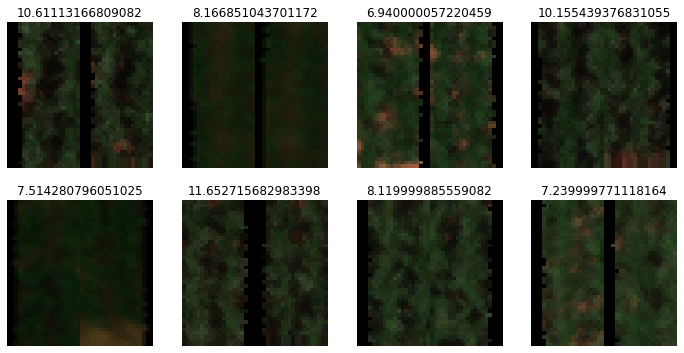

In [19]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [1]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
    
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')

tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()

pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_RGB.csv', index=False)
pred_mixed_df

## MSI - alone

In [19]:
def load_npy(fn, shuffle_band=[5,6,7,8,9,10,11,12]):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    for band in shuffle_band:
        bshuffle = im[:,:,band].flatten()
        np.random.shuffle(bshuffle)
        im[:,:,band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

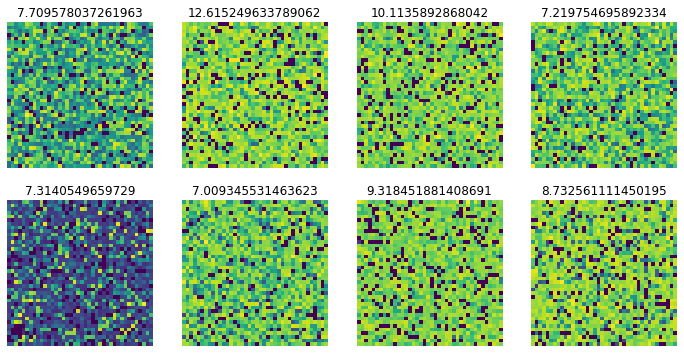

In [36]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl.show_batch(channels=7)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


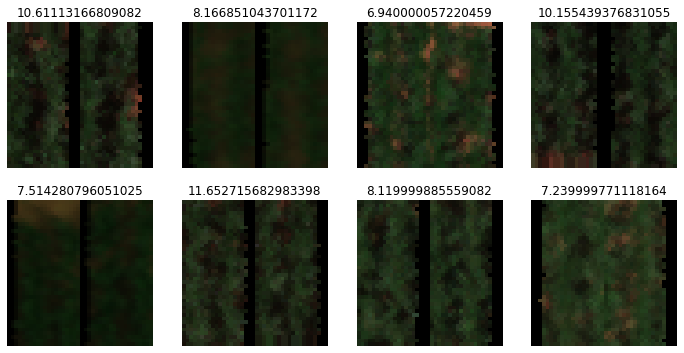

In [33]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [34]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
    
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')

tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()

pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df

,items,tab_pred,msi_pred,mixed_pred,target_yield,Class,Barcode,Year,Test,Rep,Stock,Pedigree,Yield,Parental 1,Parental 2,Planting,Sowing_date-MMDDYY,Days_after_sowing,Fertilizer
0,CS17-G2FE-043,10.043692,9.016855,9.387111,10.611132,high,CS17-G2FE-043,2017,G2FE,1.0,16.2.19716.04035.0000000,NILASQ4G21I12S2/LH123HT,10.611132,NILASQ4G21I12S2,LH123HT,optimal,03-03-17,60,optimal
1,CS19-G2LA-233,7.468921,8.148921,7.568653,8.166851,mid,CS19-G2LA-233,2019,NaN,NaN,17SGTF:LH195:1494,NaN,8.166851,PHN11_PHW65_0049,LH195,optimal,NaN,58,optimal
2,CS18-G2LA-291,9.016195,7.975060,8.739189,6.940000,mid,CS18-G2LA-291,2018,G2LA,2.0,17SGTF:LH195:0997,MO44_PHW65_0174/LH195,6.940000,MO44_PHW65_0174,LH195,optimal,03-06-18,72,optimal
3,CS17-G2FE-379,9.637484,9.564165,9.358041,10.155439,high,CS17-G2FE-379,2017,G2FE,2.0,16.2.19716.04205.0000000,NILASQ4G71I09S2/LH123HT,10.155439,NILASQ4G71I09S2,LH123HT,optimal,03-03-17,60,optimal
4,CS19-G2F1-110,7.611115,7.826789,7.791806,7.514281,mid,CS19-G2F1-110,2019,NaN,NaN,17SGTF:LH195:1633,NaN,7.514281,PHW65_MoG_0086,LH195,optimal,NaN,58,optimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,CS17-G2FE-292,11.451656,9.374105,10.716146,13.173242,high,CS17-G2FE-292,2017,G2FE,1.0,CS16-YCB-B73-X-YCB-30A,B73/TX775,13.173241,B73,TX775,optimal,03-03-17,60,optimal
771,CS19-G2LA-416,7.697612,7.033533,6.818945,8.785245,mid,CS19-G2LA-416,2019,NaN,NaN,17SGTF:LH195:0933,NaN,8.785245,Mo44_PHW65_0001,LH195,optimal,NaN,58,optimal
772,CS18-G2LA-511,7.445492,7.557189,7.223417,9.330000,mid,CS18-G2LA-511,2018,G2LA,2.0,CS17-BISO-108-X-TX9,LH132/Tx779,9.330000,LH132,Tx779,optimal,03-06-18,72,optimal
773,CS19-G2F1-187,6.992431,6.987911,6.005404,7.007439,mid,CS19-G2F1-187,2019,NaN,NaN,17SGTF:LH195:0341,NaN,7.007439,Mo44_PHW65_0063,LH195,optimal,NaN,58,optimal


In [37]:
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSI.csv', index=False)

## MSI + VIs (minus NDVI) - 5

In [22]:
def load_npy(fn, shuffle_band=5):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

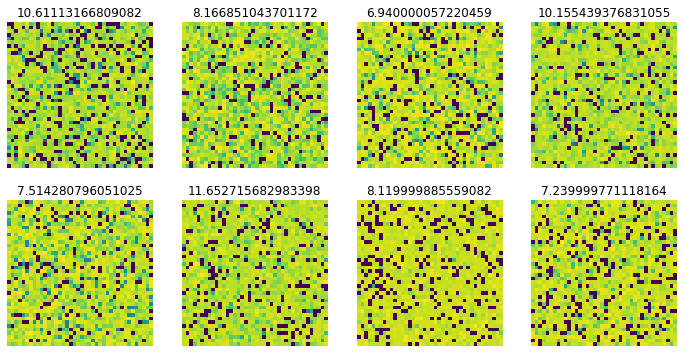

In [23]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=5)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


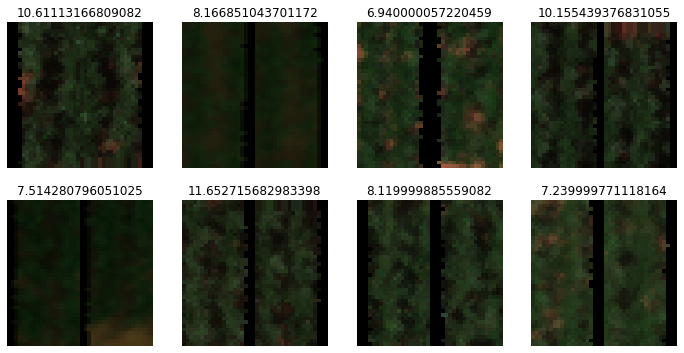

In [25]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [26]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')

In [27]:
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusNDVI.csv', index=False)

## MSI + VIs (minus NDVI2) -6

In [30]:
def load_npy(fn, shuffle_band=6):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

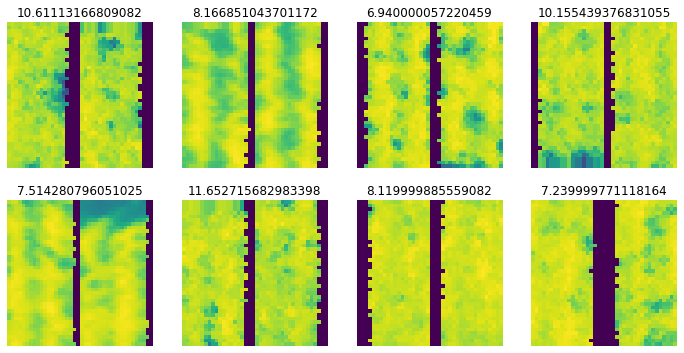

In [31]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=5)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


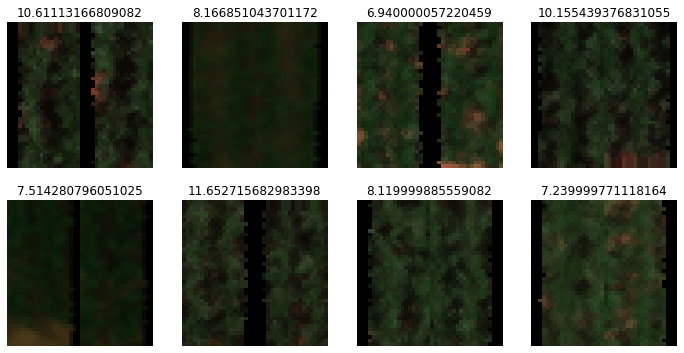

In [32]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [33]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusNDVI2.csv', index=False)

## MSI + VIs (minus NDRE) -7

In [34]:
def load_npy(fn, shuffle_band=7):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

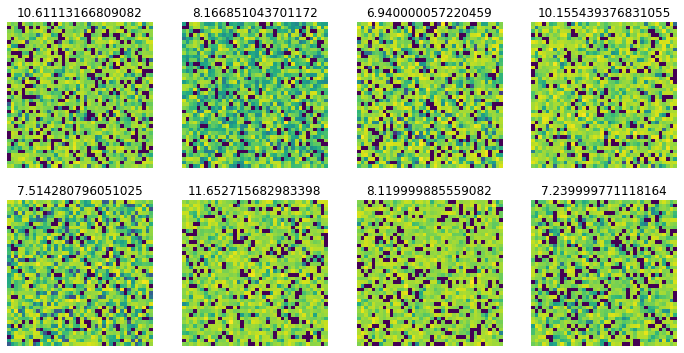

In [35]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=7)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


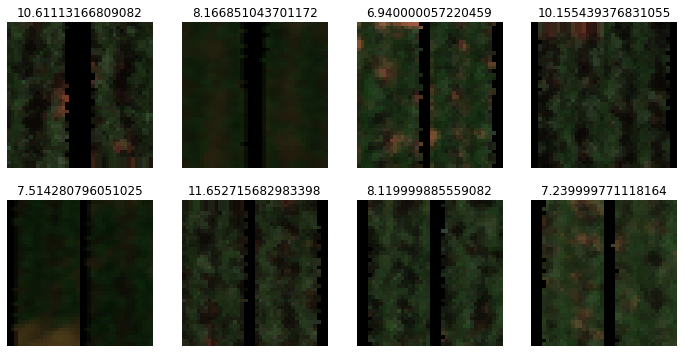

In [36]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [37]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusNDRE.csv', index=False)

## MSI + VIs (minus ENVI) -8

In [38]:
def load_npy(fn, shuffle_band=8):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

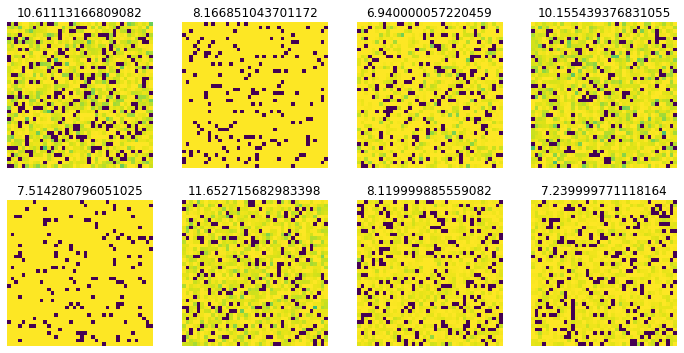

In [39]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=8)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


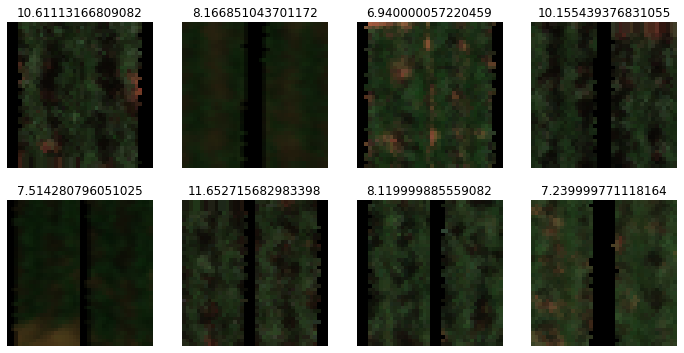

In [40]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [41]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusENVI.csv', index=False)

## MSI + VIs (minus CCCI) -9

In [42]:
def load_npy(fn, shuffle_band=9):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

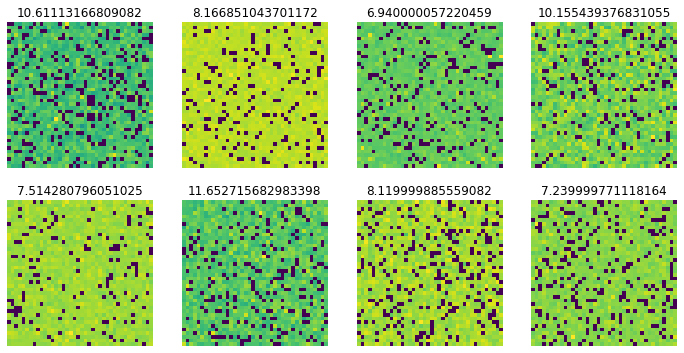

In [43]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=9)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


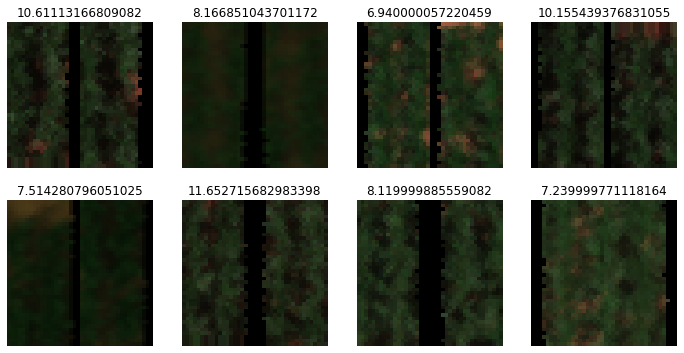

In [44]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [45]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusCCCI.csv', index=False)

## MSI + VIs (minus GNDVI) -10

In [46]:
def load_npy(fn, shuffle_band=10):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

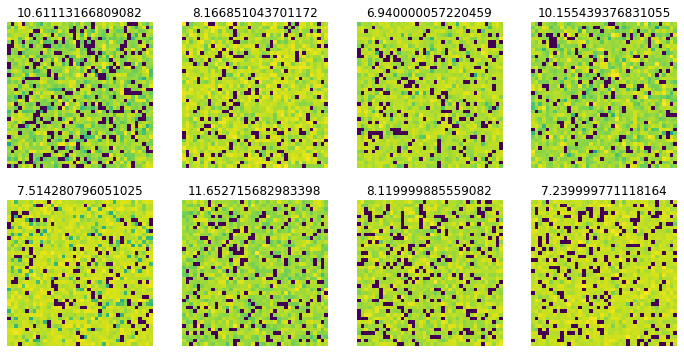

In [47]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=10)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


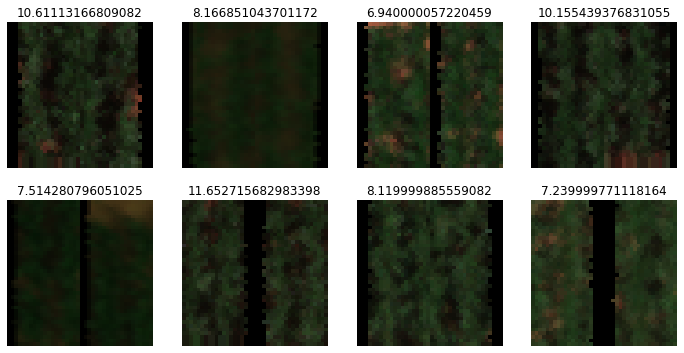

In [48]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [49]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusGNDVI.csv', index=False)

## MSI + VIs (minus GLI) -11

In [50]:
def load_npy(fn, shuffle_band=11):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

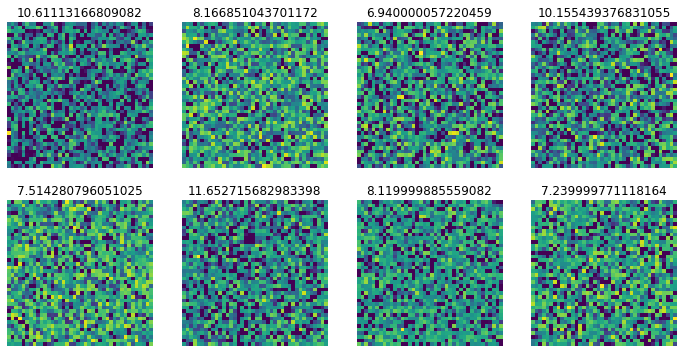

In [51]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=11)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


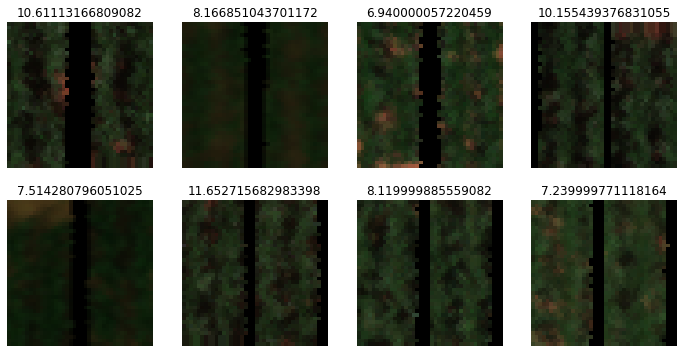

In [52]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [53]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusGLI.csv', index=False)

## MSI + VIs (minus OSAVI) -12

In [54]:
def load_npy(fn, shuffle_band=12):
    """
    Bands order:0 B, G, R, NIR, REd, 
                5 NDVI, NDVI2, NDRE, ENVI, CCCI,
                10 GNDVI, GLI, OSAVI
    """
    im = np.load(str(fn), allow_pickle=True)
    im = im*3
    
    # Padding with zeros
    w, h , c = im.shape
    im = np.pad(im, ((0, 100-w), (0, 100-h), (0,0)),mode='constant', constant_values=0)
    im = mix_npy_blocks(im) # Add transforms and stacking
    im = vegetation_idxs(im) # Add vegetation indexes bands
    
    # Feature permutation
    bshuffle = im[:,:,shuffle_band].flatten()
    np.random.shuffle(bshuffle)
    im[:,:,shuffle_band] = bshuffle.reshape([im.shape[0], im.shape[1]])
    
    for band in range(im.shape[2]):
        im[:,:,band] = np.clip(im[:,:,band], 0, 1)
        
    # Swap axes because np is:  width, height, channels
    # and torch wants        :  channel, width , height
    im = np.swapaxes(im, 2, 0)
    im = np.swapaxes(im, 1, 2) 
    im = np.nan_to_num(im)
    
    return torch.from_numpy(im)

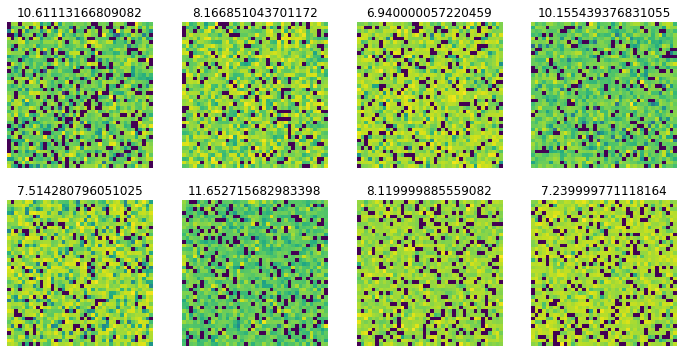

In [55]:
# MSI
msi_fold = DataBlock(blocks = (MSITensorBlock, RegressionBlock),
                          get_items = get_npy,
                          get_y = get_y,
                          splitter = splitter)
msi_dl = msi_fold.dataloaders(df_train_val, bs=8)
msi_dl[1].show_batch(channels=12)

,Parental 1,Parental 2,Planting,Stock,Fertilizer,Days_after_sowing,Yield
0,NILASQ4G21I12S2,LH123HT,optimal,16.2.19716.04035.0000000,optimal,60.0,10.611132
1,PHN11_PHW65_0049,LH195,optimal,17SGTF:LH195:1494,optimal,58.0,8.166851
2,MO44_PHW65_0174,LH195,optimal,17SGTF:LH195:0997,optimal,72.0,6.940000
3,NILASQ4G71I09S2,LH123HT,optimal,16.2.19716.04205.0000000,optimal,60.0,10.155439
4,PHW65_MoG_0086,LH195,optimal,17SGTF:LH195:1633,optimal,58.0,7.514281
5,2369,LH123HT,optimal,16.2.19716.04555.0000000.m1,optimal,60.0,11.652716
6,PHN11_PHW65_0075,LH195,optimal,17SGTF:LH195:1507,optimal,72.0,8.120000
7,LH74,PHN82,optimal,13SAJL:Nurse:0157,optimal,72.0,7.240000


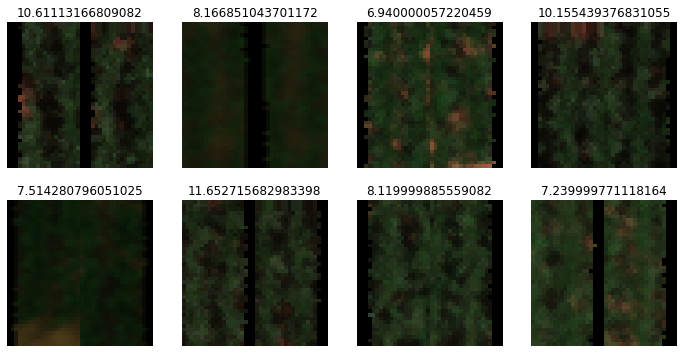

In [56]:
valid_mixed_dl = MixedDL(tab_dl[1], msi_dl[1])
valid_mixed_dl.show_batch()

In [57]:
preds,targs = multi_learn.get_preds(dl=valid_mixed_dl)
pn = msi_dl[1].items
images_id = []
for i in range(len(pn)):
    name = pn[i].stem
    images_id.append(name)
pred_mixed_df = pd.DataFrame()
pred_mixed_df['items'] = images_id
pred_mixed_df['items'] = pred_mixed_df['items'].str.replace('id_', '')
tab_pred = preds[0].flatten()
vis_pred = preds[1].flatten()
mixed_pred = preds[2].flatten()
pred_mixed_df['tab_pred'] = tab_pred
pred_mixed_df['msi_pred'] = vis_pred
pred_mixed_df['mixed_pred'] = mixed_pred
pred_mixed_df['target_yield'] = targs

pred_mixed_df = pred_mixed_df.merge(df_train_val, how='left', left_on='items', right_on='Barcode')
pred_mixed_df.to_csv('/data/results/permutation/permutation_MSIminusOSAVI.csv', index=False)